In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
from keras.models import load_model

Using TensorFlow backend.
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16

In [3]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [4]:
import xarray as xr
import numpy as np
import os

## load data

In [5]:
med_path = '../composite_median/'
s1_files = ['s1_filtered_gm_2018_vv_500.tif', 's1_filtered_gm_2018_vh_500.tif']
s1s = []
for s1_file in s1_files:
    s1s.append(xr.open_rasterio(med_path+s1_file).to_dataset(dim='band').rename({1:s1_file.split('_')[4]}))
    
s1 = xr.merge(s1s)

In [6]:
med_path = '../composite_median/'
gm_files = ['ls8_gm_2017_blue_500.tif', 'ls8_gm_2017_green_500.tif','ls8_gm_2017_red_500.tif',
            'ls8_gm_2017_nir_500.tif', 'ls8_gm_2017_swir1_500.tif', 'ls8_gm_2017_swir2_500.tif']

gms = []
for gm_file in gm_files:
    gms.append(xr.open_rasterio(med_path+gm_file).to_dataset(dim='band').rename({1:gm_file.split('_')[3]}))

gm = xr.merge(gms)

In [7]:
gm = gm.sel(x=s1.x, y=s1.y)

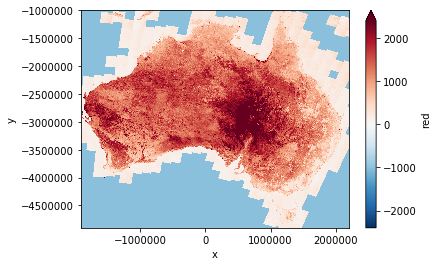

In [8]:
gm.red.plot.imshow(robust=True);

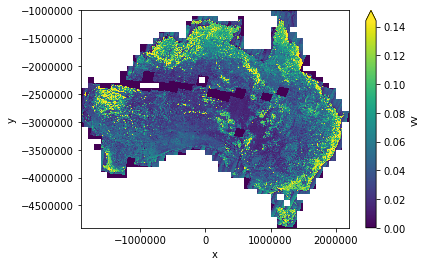

In [9]:
s1.vv.plot.imshow(robust=True);

In [10]:
data = gm[['blue','green','red','nir','swir1','swir2']].squeeze().to_array(dim='variable').transpose('y','x','variable').values
orig_shape = data.shape
data = data.reshape(orig_shape[0]*orig_shape[1],orig_shape[2])

In [11]:
output = s1.to_array(dim='variable').transpose('y','x','variable').values
output_shape = output.shape
output = output.reshape(output_shape[0]*output_shape[1],output_shape[2])

In [12]:
# train on valid data
good = ((data>0).all(axis=-1)) & (~np.isnan(data).all(axis=-1)) 
good = good & (~np.isnan(output).all(axis=-1)) & ((output>0).all(axis=-1))

/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until


In [13]:
good.sum(), data.shape

(33544836, (63960000, 6))

In [14]:
data = data[good]
output = 10*np.log10(output[good])

In [15]:
train_size = int(output.shape[0]/10)
train_size

3354483

In [16]:
ind = np.random.choice(np.arange(output.shape[0]), size=train_size)
X, Y = data[ind, :], output[ind, :]

In [17]:
X.min(), X.max(), Y.min(), Y.max()

(10, 7255, -56.018734, 13.636118)

In [18]:
Y.std(axis=0), output.std(axis=0)

(array([2.6915174, 4.300084 ], dtype=float32),
 array([4.044302, 6.709139], dtype=float32))

In [19]:
scaler_x = StandardScaler().fit(data)
scaled_x = scaler_x.transform(X)
scaler_y = StandardScaler().fit(output)
scaled_y = scaler_y.transform(Y)

In [20]:
scaled_x.mean(axis=0), scaled_y.mean(axis=0)

(array([-6.55028644e-04, -8.05908655e-05,  2.44005188e-04,  5.22294376e-04,
         3.49431676e-04,  1.94504297e-04]),
 array([0.00019823, 0.0008201 ], dtype=float32))

In [21]:
scaled_x.std(axis=0), scaled_y.std(axis=0)

(array([0.99862928, 0.99915938, 0.99948292, 0.99943045, 0.99942117,
        0.99948824]), array([0.99865794, 0.998506  ], dtype=float32))

## investigate correlations

In [22]:
data.shape, output.shape

((33544836, 6), (33544836, 2))

In [23]:
import seaborn as sns

In [24]:
import pandas as pd

In [25]:
#table_gm = pd.DataFrame(data[good], columns=list(gm.data_vars))
#table_s1 = pd.DataFrame(output[good], columns=list(s1.data_vars))

In [26]:
table = pd.concat([pd.DataFrame(scaled_x, columns=list(gm.data_vars)),pd.DataFrame(scaled_y, columns=list(s1.data_vars))],axis=1)

In [27]:
table.describe()

,blue,green,red,nir,swir1,swir2,vv,vh
count,3.354483e+06,3.354483e+06,3.354483e+06,3.354483e+06,3.354483e+06,3.354483e+06,3.354483e+06,3.354483e+06
mean,-2.726153e-04,7.091260e-05,5.264207e-05,5.224654e-04,5.755521e-04,3.594614e-04,4.101220e-04,5.196116e-04
std,9.969863e-01,9.985754e-01,9.990494e-01,9.989812e-01,9.991088e-01,9.992094e-01,9.984590e-01,9.982758e-01
min,-2.323637e+00,-2.159910e+00,-1.823997e+00,-2.383617e+00,-2.085083e+00,-1.854781e+00,-1.466317e+01,-7.978154e+00
25%,-5.507481e-01,-5.148000e-01,-6.570671e-01,-1.692938e-01,-3.464031e-01,-5.352661e-01,-6.601465e-01,-6.976338e-01
50%,-1.708433e-01,-3.252009e-02,4.649993e-02,2.203463e-01,1.884488e-01,1.107260e-01,-4.160691e-02,7.395765e-02
75%,3.356964e-01,4.444011e-01,6.136927e-01,5.583337e-01,6.187989e-01,6.613434e-01,6.700876e-01,7.563418e-01
max,1.969396e+01,1.320606e+01,8.080181e+00,5.417044e+00,3.776894e+00,4.565810e+00,9.968934e+00,5.374007e+00


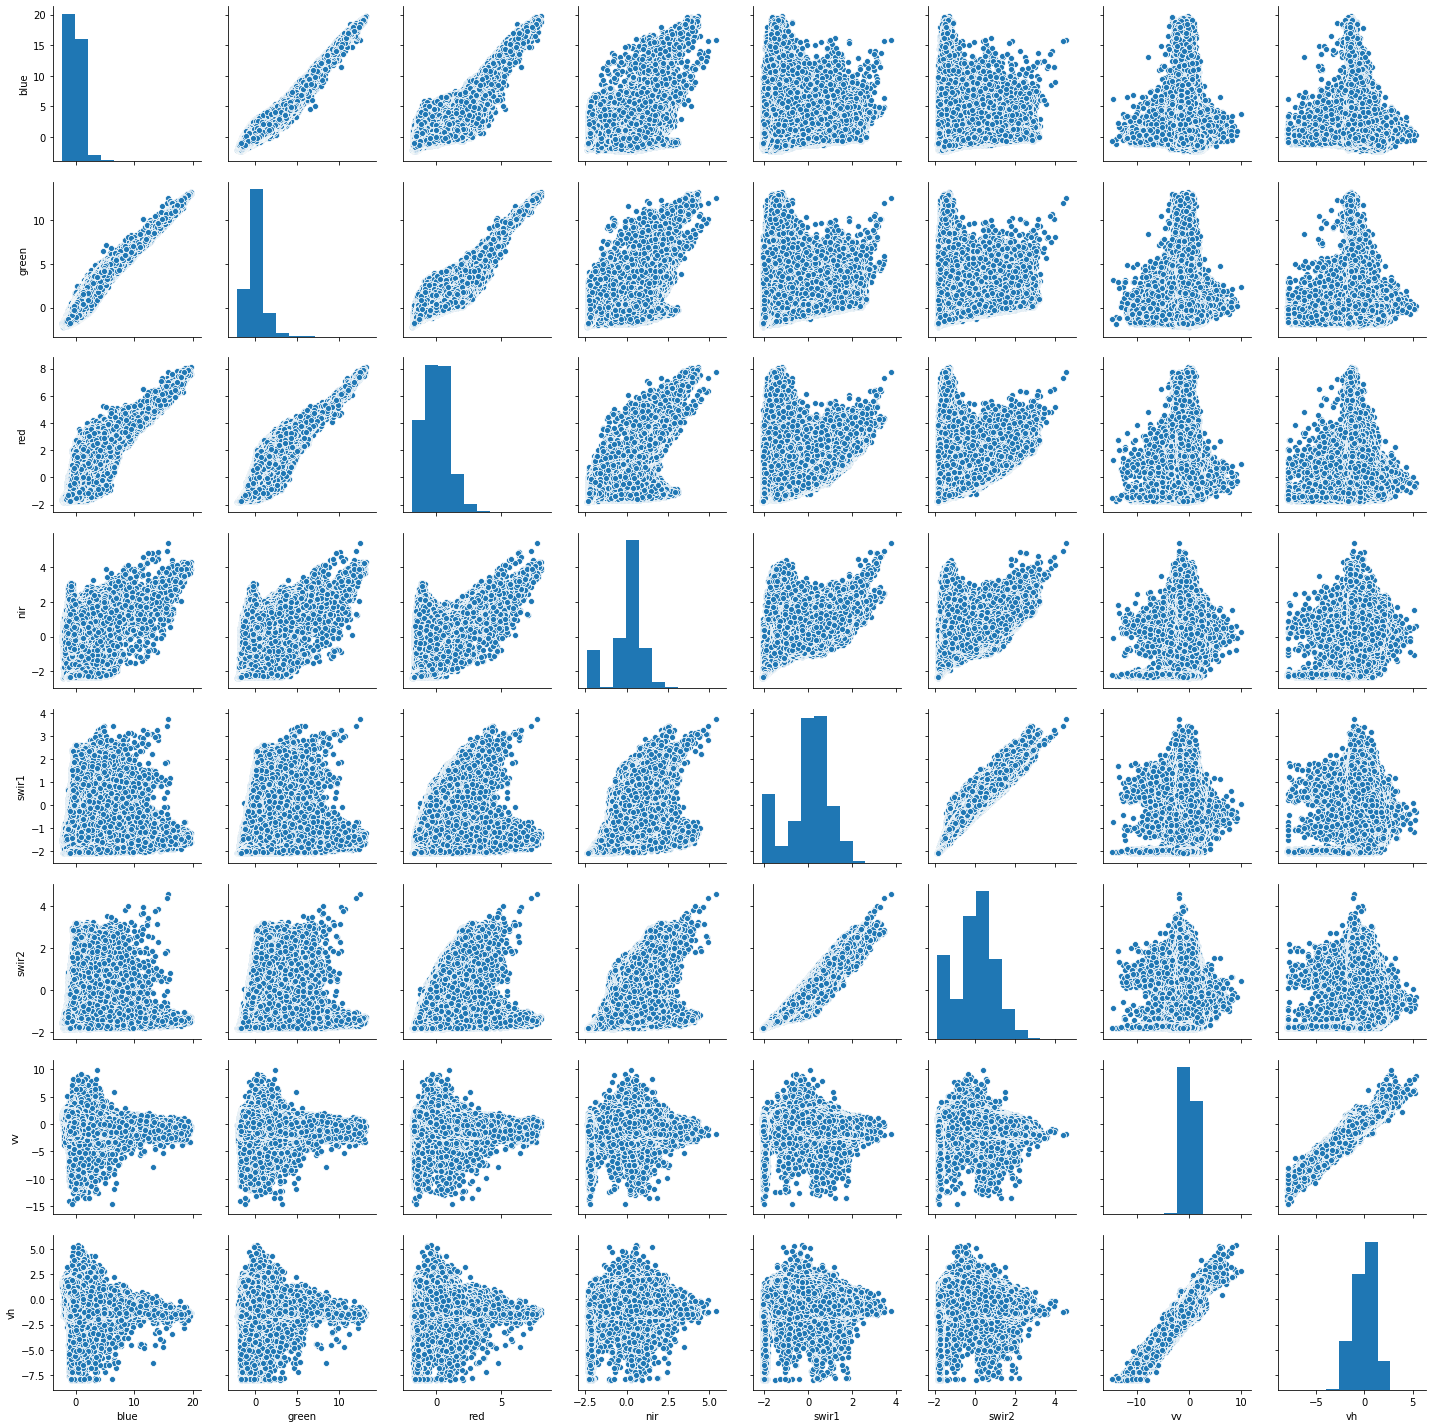

In [28]:
sns.pairplot(table)

## single layer model

In [29]:
%%time
def singlelayer_model(loss='mse'):
    # create model
    model = Sequential()
    model.add(Dense(2, input_dim=6, kernel_initializer='normal', activation='linear'))
    # Compile model
    model.compile(loss=loss, optimizer='adam')
    return model

model_file = 'single_model.h5'
if os.path.exists(model_file):
    model = load_model(model_file)
else:
    loss = 'mean_squared_error'
    #loss = 'mean_squared_logarithmic_error'
    model = singlelayer_model(loss = loss)
    model.fit(scaled_x, scaled_y, epochs = 100, batch_size=10, verbose=0)

    model.save(model_file)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
CPU times: user 11h 50min 9s, sys: 2h 31min 52s, total: 14h 22min 2s
Wall time: 7h 42min 21s


0.5344378630584025


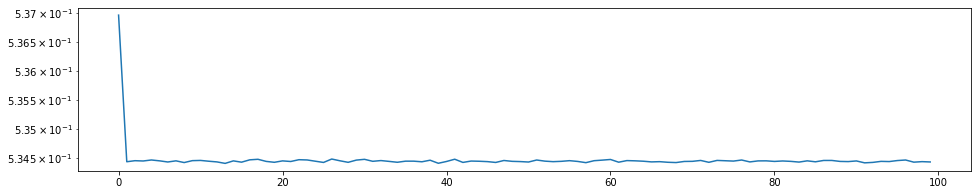

In [30]:
plt.figure(figsize=(16,3))
plt.plot(model.history.history['loss'])
plt.yscale('log')
print(model.history.history['loss'][-1])

In [31]:
%%time
predicted = model.predict(scaler_x.transform(data))

CPU times: user 5min 12s, sys: 50.3 s, total: 6min 3s
Wall time: 4min 6s


In [32]:
predicted = scaler_y.inverse_transform(predicted)
test = np.empty((good.shape[0],2))
test.fill(np.nan)
test[good, 0] = predicted[:,0]
test[good, 1] = predicted[:,1]

In [33]:
s1['predicted_vv'] = ('y','x'), test[:,0].reshape(orig_shape[0], orig_shape[1])
s1['predicted_vh'] = ('y','x'), test[:,1].reshape(orig_shape[0], orig_shape[1])

In [28]:
s1['vv_db'] = 10*np.log10(s1.vv.where(s1.vv>0))
s1['vh_db'] = 10*np.log10(s1.vh.where(s1.vh>0))

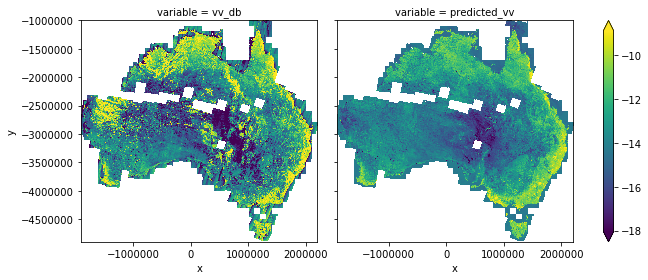

In [35]:
s1[['vv_db', 'predicted_vv']].to_array(dim='variable').plot.imshow(col='variable', robust=True, figsize=(10,4));

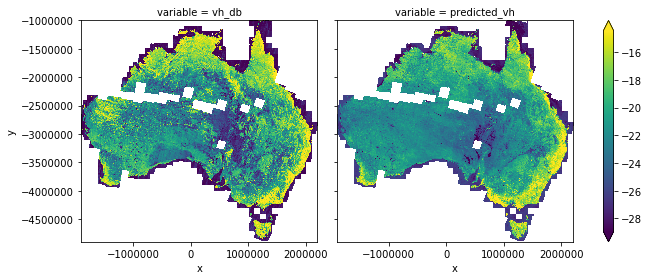

In [36]:
s1[['vh_db', 'predicted_vh']].to_array(dim='variable').plot.imshow(col='variable', robust=True, figsize=(10,4));

In [37]:
s1.mean()

<xarray.Dataset>
Dimensions:       ()
Data variables:
    vv            float32 0.049381807
    vh            float32 0.009730231
    predicted_vv  float64 -13.58
    predicted_vh  float64 -21.68
    vv_db         float32 -13.57051
    vh_db         float32 -21.67196

## multi-layer model

In [32]:
%%time

def baseline_model(loss):
    # create model
    model = Sequential()
    model.add(Dense(10, input_dim=6, kernel_initializer='normal', activation='relu'))
    model.add(Dense(5, kernel_initializer='normal',activation='relu'))
    model.add(Dense(2, kernel_initializer='normal', activation='linear'))
    # Compile model
    model.compile(loss=loss, optimizer='adam')
    return model

# evaluate model with standardized dataset
#estimators = []
#estimators.append(('standardize', StandardScaler()))
#estimators.append(('mlp', KerasRegressor(build_fn=baseline_model, epochs=50, batch_size=10, verbose=1)))
#pipeline = Pipeline(estimators)
#kfold = KFold(n_splits=5)
#results = cross_val_score(pipeline, X, Y, cv=kfold)
#print("Wider: %.2f (%.2f) MSE" % (results.mean(), results.std()))
#pipeline.fit(X,Y)

bmodel_file = 'multi_model.h5'
if os.path.exists(bmodel_file):
    bmodel = load_model(bmodel_file)
else:   
    loss = 'mean_squared_error'
    #loss = 'mean_squared_logarithmic_error'
    bmodel = baseline_model(loss = loss)
    bmodel.fit(scaled_x, scaled_y, epochs = 250, batch_size=10, verbose=0)
    bmodel.save(bmodel_file)

CPU times: user 991 ms, sys: 36 ms, total: 1.03 s
Wall time: 2.52 s


In [37]:
help(bmodel)

Help on Sequential in module keras.engine.sequential object:

class Sequential(keras.engine.training.Model)
 |  Linear stack of layers.
 |  
 |  # Arguments
 |      layers: list of layers to add to the model.
 |      name: Name given to the model
 |  
 |  # Example
 |  
 |  ```python
 |  # Optionally, the first layer can receive an `input_shape` argument:
 |  model = Sequential()
 |  model.add(Dense(32, input_shape=(500,)))
 |  
 |  # Afterwards, we do automatic shape inference:
 |  model.add(Dense(32))
 |  
 |  # This is identical to the following:
 |  model = Sequential()
 |  model.add(Dense(32, input_dim=500))
 |  
 |  # And to the following:
 |  model = Sequential()
 |  model.add(Dense(32, batch_input_shape=(None, 500)))
 |  
 |  # Note that you can also omit the `input_shape` argument:
 |  # In that case the model gets built the first time you call `fit` (or other
 |  # training and evaluation methods).
 |  model = Sequential()
 |  model.add(Dense(32))
 |  model.add(Dense(32))
 | 

0.331372101228922


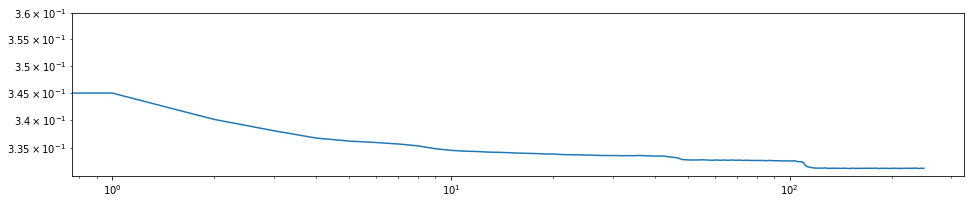

In [23]:
plt.figure(figsize=(16,3))
plt.plot(bmodel.history.history['loss'])
plt.yscale('log')
plt.xscale('log')
print(bmodel.history.history['loss'][-1])

In [24]:
%%time
predicted = bmodel.predict(scaler_x.transform(data))

CPU times: user 7min 19s, sys: 1min 4s, total: 8min 24s
Wall time: 14min 56s


In [25]:
predicted = scaler_y.inverse_transform(predicted)
test = np.empty((good.shape[0],2))
test.fill(np.nan)
test[good, 0] = predicted[:,0]
test[good, 1] = predicted[:,1]

In [26]:
s1['predicted_vv'] = ('y','x'), test[:,0].reshape(orig_shape[0], orig_shape[1])
s1['predicted_vh'] = ('y','x'), test[:,1].reshape(orig_shape[0], orig_shape[1])

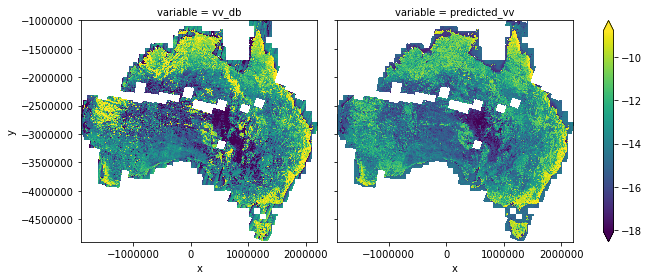

In [29]:
s1[['vv_db', 'predicted_vv']].to_array(dim='variable').plot.imshow(col='variable', robust=True, figsize=(10,4));

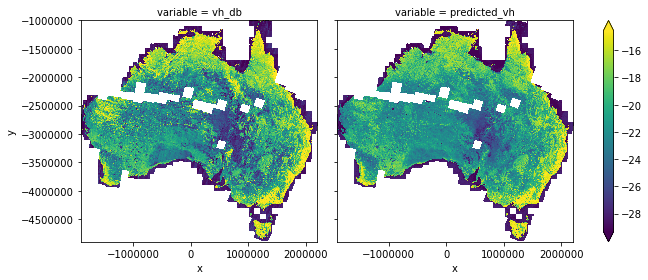

In [30]:
s1[['vh_db', 'predicted_vh']].to_array(dim='variable').plot.imshow(col='variable', robust=True, figsize=(10,4));

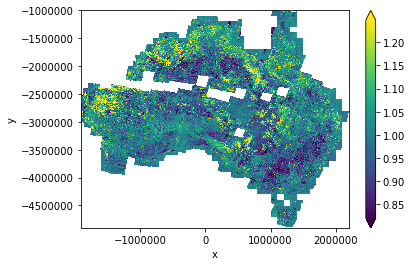

In [31]:
(s1.predicted_vh/s1.vh_db).plot.imshow(robust=True);